## Necessary imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Importing libraries for Data Gathering & Manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import figure
from scipy.spatial.distance import euclidean as eu
import math
from scipy import signal
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import preprocessing

import glob



import os
# Importing Libraries for Binning
import numpy as np 
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import preprocessing
from scipy.fftpack import fft, ifft




# Importing the necessary libraries for building neural network and k-means clustering
from sklearn.datasets import load_digits
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

In [8]:
import os
import pandas as pd

# Path to the folders containing the data
dyslexia_folder = "Data/Dyslexic"
control_folder = "Data/Control"

# Function to load data from folder
def load_data_from_folder(folder, label):
    data_list = []
    for filename in os.listdir(folder):
        if filename.endswith(".csv"):
            data = pd.read_csv(os.path.join(folder, filename))
            # Create a unique identifier for each patient based on CSV file name
            data["patient_id"] = filename.split(".")[0]  # Extract patient ID from filename
            data["label"] = label  # Add label column
            
            # Determine gender and reading ability based on filename
            if filename.endswith("1.csv") or filename.endswith("3.csv"):
                data["gender"] = "male"
                data["reading_ability"] = "disabled"
            else:
                data["gender"] = "female"
                data["reading_ability"] = "enabled"
            
            data_list.append(data)
    return data_list

# Load dyslexia samples
D_data = load_data_from_folder(dyslexia_folder, "dyslexia")

# Load control samples
C_data = load_data_from_folder(control_folder, "control")

# Combine data into a single DataFrame
df = pd.concat(D_data + C_data, ignore_index=True)



In [9]:
df

,Unnamed: 0,T,LX,LY,RX,RY,patient_id,label,gender,reading_ability
0,0,0.0,0.00000,0.00000,0.00000,0.00000,111JA2,dyslexia,female,enabled
1,1,20.0,-0.00001,0.00000,0.65535,-0.65536,111JA2,dyslexia,female,enabled
2,2,40.0,-0.00001,-0.65537,0.65536,-1.31073,111JA2,dyslexia,female,enabled
3,3,60.0,0.65536,-1.96609,0.65536,-1.96609,111JA2,dyslexia,female,enabled
4,4,80.0,0.65536,-1.96609,1.31072,-1.96609,111JA2,dyslexia,female,enabled
...,...,...,...,...,...,...,...,...,...,...
325059,1494,29880.0,-49.15286,57.01693,-48.49750,57.01693,831PA3,control,male,disabled
325060,1495,29900.0,-49.15286,57.01693,-48.49750,57.01693,831PA3,control,male,disabled
325061,1496,29920.0,-49.15286,57.01693,-48.49750,57.01693,831PA3,control,male,disabled
325062,1497,29940.0,-49.15286,57.01693,-48.49750,57.01693,831PA3,control,male,disabled


In [10]:
# We need to make sure that the samples we extracted have some rows where fraud is True
patient_label_map = dict(df[['patient_id', 'label']].values)

# Filter the DataFrame for fraudulent samples based on patient label
fraudulent_samples = df[df['patient_id'].apply(lambda x: patient_label_map[x] == 'dyslexia')]

# Display the shape of the filtered DataFrame
print("Number of fraudulent dyslexia samples:", fraudulent_samples.shape[0])

Number of fraudulent dyslexia samples: 194902


In [ ]:
percent_missing=(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90)

The card_id is defined as one card by one user. A specific user can have multiple cards, which would correspond to multiple different card_ids for this graph. 
For this reason we will create a new column which is the concatenation of the column User and the Column Card

In [ ]:
df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)

In [ ]:
df.Amount.head(5)

In [ ]:
# We need to strip the ‘$’ from the Amount to cast as a float
df["Amount"]=df["Amount"].str.replace("$","").astype(float)

In [ ]:
# time can't be casted to int so so opted to extract the hour and minute
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]

In [ ]:
df.Hour

In [ ]:
df.Minute

In [ ]:
df = df.drop(["Time","User","Card"],axis=1)
df.info()

In [ ]:
df["Errors?"].unique()

In [ ]:
df["Errors?"]= df["Errors?"].fillna("No error")

The two columns Zip and Merchant state contains missing values which can affect our graph. Moreover these information can be extracted from the column Merchant City so we will drop them.

In [ ]:
df = df.drop(columns=["Merchant State","Zip"],axis=1)

In [ ]:
# change the is fraud column to binary 
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
df["Merchant City"]=LabelEncoder().fit_transform(df["Merchant City"])
df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])
df["Errors?"]=LabelEncoder().fit_transform(df["Errors?"])

In [ ]:
df["Errors?"].unique()

In [ ]:
df.info()

## GNN for fraud detection:
Creating a multigraph for fraud detection using transaction data and applying a Graph Neural Network (GNN) on the edge list can be done in the following steps:

1. Prepare the transaction data: Collect and organize the transaction data into a format that can be used to create the edges of the multigraph. For example, each transaction could be represented as a tuple (node1, node2, attributes), where node1 and node2 represent the sender and receiver of the transaction, and attributes is a dictionary containing properties such as the amount, timestamp, and transaction type.

2. Create the multigraph: Use the transaction data to create a multigraph using the NetworkX library. The add_edge() method can be used to add edges to the multigraph, where each edge represents a transaction.

3. Extract the edges list and their features: Use the edges() method of the multigraph to extract the edges list and their features, which will be used as input to the GNN.

4. Apply a GNN on the edge list: Use a GNN library such as PyTorch Geometric, Deep Graph Library (DGL) or Spektral to apply a GNN on the edge list. The GNN will learn representations of the edges in the multigraph and use them to classify the edges as fraudulent or non-fraudulent.

5. Evaluation: To evaluate the performance of the GNN, you can split the data into train and test sets, and use the test set to evaluate the accuracy, precision, recall, and F1-score of the model.

### Graph construction 

When constructing a graph with transaction edges between card_id and merchant_name, the first step is to identify the nodes in the graph. In this case, the card_id and merchant_name represent the nodes in the graph. Each card_id represents a unique credit card and each merchant_name represents a unique merchant. These nodes can be created by extracting the card_id and merchant_name information from the tabular data and storing them in separate lists.

Once the nodes have been identified, the next step is to create edges between them. These edges represent the transactions that have taken place between a card_id and a merchant_name. To create the edges, a list of transactions is created and for each transaction, an edge is created between the card_id and merchant_name.


### Method 1

We are creating an empty multigraph object called G using the nx.MultiGraph() function from the NetworkX library. Then we add nodes to the graph for each unique card_id and merchant_name from the dataframe df.

The add_nodes_from method is used to add nodes to the graph, it takes an iterable as input and creates a node for each element in the iterable. The df["card_id"].unique() will return a list of unique card_ids in the dataframe, and the df["Merchant Name"].unique will return a list of all the merchant names in the dataframe.

The type attribute is added to each node, it is used to differentiate between card_id and merchant_name nodes. This will help later on when we want to analyze the graph.

**Why did we use a multigraph and not graph?**

The same user (card_id) can buy from the same merchant (Merchant Name) multiple times, so we can have multiple edges between the user and the merchant and for this reason we used multigraph instead of graph 

  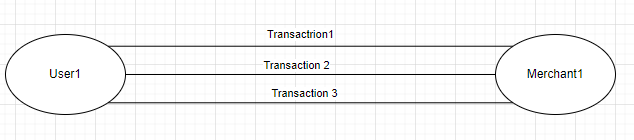


In [ ]:
# Create an empty graph
G = nx.MultiGraph()

# Add nodes to the graph for each unique card_id, merchant_name
G.add_nodes_from(df["card_id"].unique(), type='card_id')
G.add_nodes_from(df["Merchant Name"].unique(), type='merchant_name')


The code below adding edges and properties to the edges of a graph. The code iterates through each row of the dataframe, df, and creates a variable for each property then assign it to the edge between the card_id and merchant_name of that row.

In [ ]:
# Add edges and properties to the edges 
for _, row in df.iterrows():
    # Create a variable for each properties for each edge
    
        year = row["Year"],
        month = row["Month"],
        day = row["Day"],
        hour = row["Hour"],
        minute =row["Minute"],
        amount = row["Amount"],
        use_chip =  row["Use Chip"],
        merchant_city = row["Merchant City"],
        errors =  row["Errors?"],
        mcc = row['MCC']
    
 
        G.add_edge(row['card_id'], row['Merchant Name'], year = year , month = month , day = day ,
              hour = hour , minute = minute , amount = amount , use_chip = use_chip ,
              merchant_city = merchant_city , errors = errors , mcc = mcc)
  


In [ ]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the number of nodes and edges
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

In [ ]:
# Convert the graph to an adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

In [ ]:
adj_matrix.shape

We will retrieve the properties of a small sample of **nodes** in our graph (G) and print their properties.

In [ ]:
# Get a small sample of the nodes in the graph
sample_nodes = list(G.nodes())[:10]

# Retrieve the properties of the sample nodes
node_properties = nx.get_node_attributes(G, 'type')

# Print the properties of the sample nodes
for node in sample_nodes:
    print(f"Node: {node}, Properties: {node_properties[node]}")


In [ ]:
sample_size = 5
for i, edge in enumerate(G.edges()):
    print(G.get_edge_data(*edge))
    if i >= sample_size - 1:
        break

We will retrieve the properties of a small sample of **edges** in our graph (G) and print their properties.

In [ ]:
# Retrieve the properties errors of all the edges
edge_properties = nx.get_edge_attributes(G, 'errors')

# Count the number of edges by property value
edge_count_by_property = Counter(edge_properties.values())

# Print the count of edges by property value
for property_value, count in edge_count_by_property.items():
    print(f"Property value: {property_value}, Count: {count}")


In [ ]:
# Prepare the data for input into the model
edge_list = list(G.edges(data=True))

In [ ]:
list(edge_list[i][2].values())

We define a PyTorch neural network model called "FraudGNN" which is a type of Graph Neural Network. The model is a simple feedforward neural network with two fully connected (Linear) layers. The first layer has input_dim number of input units and hidden_dim number of output units, while the second layer has hidden_dim number of input units and 1 output unit.
The forward function of the model applies the linear layers to the input tensor "x" and applies a ReLU activation function to the output of the first linear layer.

We also prepare data for input into the model. We define the variable "edge_list" which is a list of edges and their associated data in a graph G. Then we create an empty list called "x" and iterates over each edge in the edge_list. For each edge, it extracts the values of the edge data, converts them to floats if needed, and append them to the list "x". Finally, we convert the list "x" to a PyTorch tensor with float datatype, which is ready to be input into the FraudGNN model.

In [ ]:
class FraudGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FraudGNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.squeeze(-1)

# Prepare the data for input into the model
edge_list = list(G.edges(data=True))
x = []
for edge in edge_list:
    edge_values = list(edge[2].values())
    edge_values = [float(i[0]) if type(i) == tuple and type(i[0]) == str else i[0] if type(i) == tuple else i for i in edge_values]
    x.append(edge_values)
x = torch.tensor(x, dtype=torch.float)

In [ ]:
target = torch.tensor(df['Is Fraud?'].values, dtype=torch.float)

In [ ]:
# Define the model
input_dim = len(x[0])
hidden_dim = 16
model = FraudGNN(input_dim, hidden_dim)
num_epochs=201

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train the model
for i in range(num_epochs):
    # Forward pass
    output = model(x)
    # Compute the loss
    loss = criterion(output, target)
    if i % 20 == 0:
        print(f'Epoch: {i}, Loss: {loss.item()}')
    # Zero the gradients
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # Update the parameters
    optimizer.step()

### Method 2 

In this part we will base our work on the [paper](https://www.sciencedirect.com/science/article/abs/pii/S0957417421017449) **Inductive Graph Representation Learning for fraud detection** written by RafaëlVan Belle, Charles Van Damme, Hendrik Tytgat and JochenDe Weerdt. 

Charles has created a python library with the name of inductiveGRL for the experimental setup of their paper. 

Library overview :

1. Transaction Data
Any dataset that can be transformed into a graph can be used in our experimental setup. For our research, we used a real-life dataset to construct credit card transaction networks containing millions of transactions. This dataset includes information on the following features: anonymized identification of clients and merchants, merchant category code, country, monetary amount, time, acceptance, and fraud label. This real-life dataset is highly imbalanced and contains only 0.65% fraudulent transactions. Note that the demo data in this repository is artificaly generated for demonstration purposes. The Timeframes component derives the different timeframes for a rolling window setup given a step and window size.

2. Graph Construction
The GraphConstruction component constructs the graphs that will be used by graph representation learners (e.g. FI-GRL and GraphSAGE) to learn node embeddings. We designed the credit card transaction networks as heterogeneous tripartite graphs containing client, merchant and transaction nodes. Because of this tripartite setup, representations can be learned for the transaction nodes. Only the transaction nodes are configured with node features.

3. GraphSAGE
The HinSAGE code deploys a supervised, heterogeneous implementation of the GraphSAGE framework called HinSAGE, to learn embeddings of the transaction nodes in the aforementioned graphs.

4. FI-GRL
The FIGRL code learns embeddings of the transaction nodes in the aforementioned graphs using the Fast Inductive Graph Representation Learning Framework. We call the Matlab implementation of FI-GRL from our Jupyter notebooks, which requires an appropriate installation of matlab.engine in the same folder as the notebooks. If you wish to run FI-GRL from Python, please run the following command in Matlab:

cd (fullfile(matlabroot,'extern','engines','python'))
system('python setup.py install')

This will generate a folder in matlabroot\extern\engines\python\build\lib called 'matlab' please copy this folder and place it on the same location as the notebook from which you want to call matlab.engine. If you don't know your matlab root, running 'matlabroot' in Matlab will return the appropriate path.

5. Classifier
The penultimate component in our pipeline uses the transaction node embeddings to classify the transaction nodes as fraudulent or legitimate. We chose to rely on XGBoost as a classification model, but other classifiers can easily be implemented.

6. Evaluation
The Evaluation component contains functions for the Lift score, Lift curve and precision-recall curve. We focused on these evaluation metrics given the highly imbalanced nature of our dataset. However, this code can easily be extended to contain other evaluation metrics such as ROC plots.

In [ ]:
#library installation
!pip install inductiveGRL 

In [ ]:
# necessary imports of this part
from inductiveGRL.graphconstruction import GraphConstruction
from inductiveGRL.hinsage import HinSAGE_Representation_Learner

In [ ]:
# Global parameters:
embedding_size = 64
add_additional_data = True

We will split our data 70% to train_data and 30% for inductive data that will be used to test the model's ability to generalize to new, unseen data.

First we calculate the cutoff point for the split using the formula "cutoff = round(0.7*len(df))" where 0.7 represents 70% of the data, and len(df) is the total number of rows in the dataframe. The round function is used to round the cutoff point to the nearest whole number.

Second we assign the first "cutoff" rows of the dataframe to the variable "train_data" by calling the head() function on the dataframe and passing the cutoff point as an argument. These rows will be used as the training data.

Last we assign the remaining rows of the dataframe (the rows after the cutoff point) to the variable "inductive_data" by calling the tail() function on the dataframe and passing the number of remaining rows (len(df) - cutoff) as an argument. These rows will be used as the inductive data.

In [ ]:
# we will take 70% of our dataset as traindata
cutoff = round(0.7*len(df)) 
train_data = df.head(cutoff)
inductive_data = df.tail(len(df)-cutoff)

In [ ]:
print('The distribution of fraud for the train data is:\n', train_data['Is Fraud?'].value_counts())
print('The distribution of fraud for the inductive data is:\n', inductive_data['Is Fraud?'].value_counts())

#### Graphe construction 

We will create a graph from a train_data using the GraphConstruction class. First we create the dataframes for the node data, second we define the nodes and edges, third  we create a dictionary of features, and finally we create a graph object, and calls the get_stellargraph() method to get the StellarGraph object.

In [ ]:
transaction_node_data = train_data.drop("card_id", axis=1).drop("Merchant Name", axis=1).drop('Is Fraud?', axis=1)
client_node_data = pd.DataFrame([1]*len(train_data["card_id"].unique())).set_index(train_data["card_id"].unique())
merchant_node_data = pd.DataFrame([1]*len(train_data["Merchant Name"].unique())).set_index(train_data["Merchant Name"].unique())

nodes = {"client":train_data.card_id, "merchant":train_data["Merchant Name"], "transaction":train_data.index}
edges = [zip(train_data.card_id, train_data.index),zip(train_data["Merchant Name"], train_data.index)]
features = {"transaction": transaction_node_data, 'client': client_node_data, 'merchant': merchant_node_data}

graph = GraphConstruction(nodes, edges, features)
S = graph.get_stellargraph()
print(S.info())

In [ ]:
#GraphSAGE parameters
num_samples = [2,32]
embedding_node_type = "transaction"

hinsage = HinSAGE_Representation_Learner(embedding_size, num_samples, embedding_node_type)
trained_hinsage_model, train_emb = hinsage.train_hinsage(S, list(train_data.index), train_data['Is Fraud?'], batch_size=5, epochs=10)

## Bibliogtaphy : 

**Papers** 

Inductive Graph Representation Learning for fraud detection (paper)  : [Link](https://www.sciencedirect.com/science/article/abs/pii/S0957417421017449)

Intelligent Financial Fraud Detection Practices: An
Investigation : [Link](https://arxiv.org/ftp/arxiv/papers/1510/1510.07165.pdf)

Modeling Relational Data with Graph Convolutional Networks : [Link](https://arxiv.org/pdf/1703.06103.pdf) 

For more papers check this github [link](https://github.com/benedekrozemberczki/awesome-fraud-detection-papers)

**Library** 

Inductive-Graph-Representation-Learning-for-Fraud-Detection (library) : [Link](https://github.com/Charlesvandamme/Inductive-Graph-Representation-Learning-for-Fraud-Detection)

**Dataset** 

IBM dataset : 
* [Link1](https://github.com/IBM/TabFormer) github
* [Link2](https://ibm.ent.box.com/v/tabformer-data) IBM@Box
* [Link3](https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions) kaggle

**Others** 

11 Categorical Encoders and Benchmark : [Link](https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark#1.-Label-Encoder-(LE),-Ordinary-Encoder(OE)) 

StellarGraph : [Link](https://stellargraph.readthedocs.io/en/stable/README.html#example-gcn)

NetworkX : [Link](https://networkx.org)